# S7: Scores and pvalues explaination

In [1]:
import sys
sys.path.append('../../')
from global_variables import WORKSPACE
import socket
print("Working node:", socket.gethostname())

Working node: irbccn38.hpc.irbbarcelona.pcb.ub.es


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
def get_gene_scores(working_dir, gene):

    df_obs = f"{gene}.observed.csv"
    df_obs = pd.read_csv(f"{working_dir}/{df_obs}")
    sim_df = f"{gene}.simulated.npy"
    sim_df = np.load(f"{working_dir}/{sim_df}")
    sim_cut_df = f"{gene}.simulated_cut.npy"
    sim_cut_df = np.load(f"{working_dir}/{sim_cut_df}")
    sim_cut_std_df = f"{gene}.simulated_cut_with_std.npy"
    sim_cut_std_df = np.load(f"{working_dir}/{sim_cut_std_df}")

    df_sim = pd.DataFrame(sim_cut_df).iloc[:, 1:]
    df_sim = df_sim.T.melt(var_name="Rank", value_name="Score")

    df_sim_std = pd.DataFrame(sim_cut_std_df).iloc[:, 1:]
    df_sim_std = df_sim_std.T.melt(var_name="Rank", value_name="Score")

    return df_obs, df_sim, df_sim_std

/tmp/ipykernel_404857/107799407.py:29: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=axes[0], x="Rank", y="Score", data=df_sim_larger, jitter=0.25, alpha=1, palette=rank_colors, zorder=1, label=r"Synthetic score ($x > s$)")
/tmp/ipykernel_404857/107799407.py:55: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=axes[1], x="Rank", y="Score", data=df_sim_larger, jitter=0.25, alpha=1, palette=rank_colors, zorder=1, label=r"Synthetic score ($x + \sigma(D(n)) > s$)")


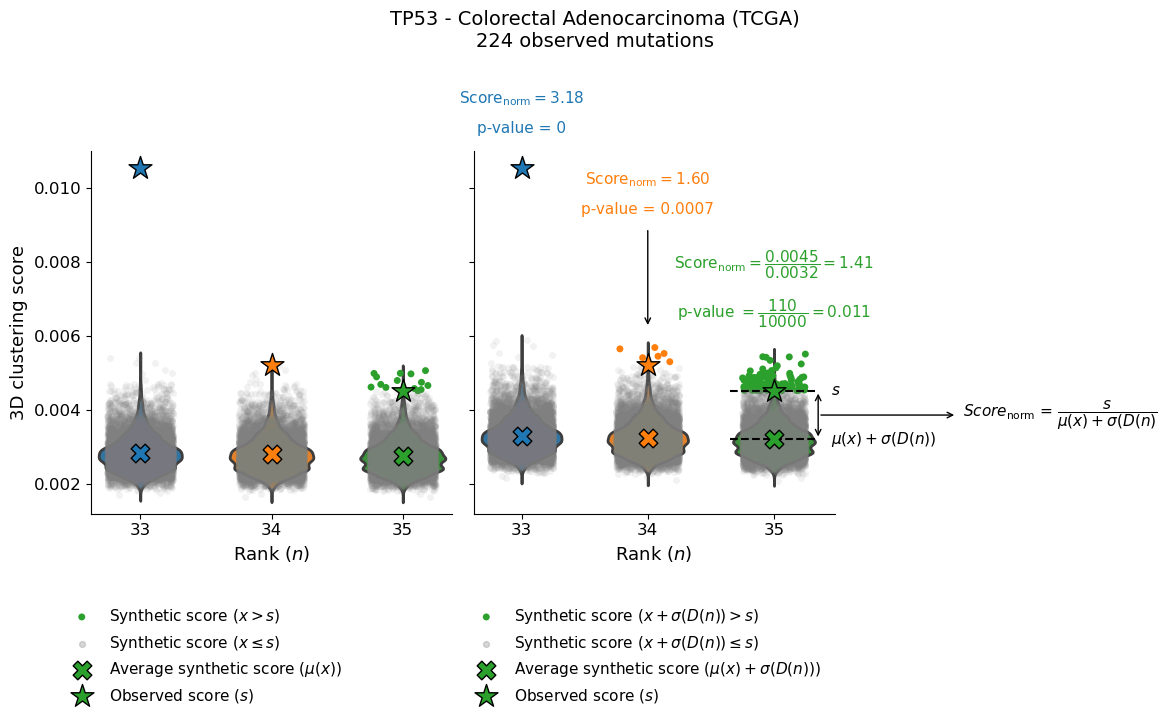

In [19]:
working_dir = F"{WORKSPACE}/projects/clustering_3d/dev_testing/score_distribution/workspace/projects/clustering_3d/dev_testing/score_distribution/work/e6/4011862c4b7f3d917bdf3570c9909b/"
gene = "TP53"
ranks = range(33,36)

cohort = [file for file in os.listdir(working_dir) if file.startswith("TCGA")][0].split(".")[0]
df_obs, df_sim, df_sim_std = get_gene_scores(working_dir, gene)
mut_count = df_obs.Mut_in_gene.unique()[0]
if ranks is not None:
    df_sim = df_sim[df_sim["Rank"].isin(ranks)].reset_index(drop=True)
    df_obs = df_obs[df_obs["Rank"].isin(ranks)].reset_index(drop=True)
    df_sim_std = df_sim_std[df_sim_std["Rank"].isin(ranks)].reset_index(drop=True)


# Plot
# ====

fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)


# Plot 1
# ------

sns.violinplot(ax=axes[0], x="Rank", y="Score", data=df_sim, linewidth=2, inner=None, zorder=0, width=0.65)

df_sim_larger = df_sim[df_sim.apply(lambda x: x.Score >= df_obs[df_obs["Rank"] == x.Rank].Score.values[0], axis=1)]
df_sim_smaller = df_sim[df_sim.apply(lambda x: x.Score < df_obs[df_obs["Rank"] == x.Rank].Score.values[0], axis=1)]
rank_colors = {str(rank): f"C{i}" for i, rank in enumerate(df_sim["Rank"].unique())}
sns.stripplot(ax=axes[0], x="Rank", y="Score", data=df_sim, jitter=0.24, alpha=1, color="white", zorder=-1)
sns.stripplot(ax=axes[0], x="Rank", y="Score", data=df_sim_larger, jitter=0.25, alpha=1, palette=rank_colors, zorder=1, label=r"Synthetic score ($x > s$)")
sns.stripplot(ax=axes[0], x="Rank", y="Score", data=df_sim_smaller, jitter=0.25, alpha=0.1, color="gray", zorder=1, label=r"Synthetic score ($x \leq s$)")
ix = range(len(df_sim.Rank.unique()))
axes[0].scatter(ix, df_obs.Score.values, s=18, zorder=0, color="gray", alpha=0.3, label=r"Synthetic score ($x \leq s$)")

# Average and observed
means = df_sim.groupby("Rank")["Score"].mean()
for i, mean in enumerate(means):
    axes[0].scatter(i, mean, s=180, ec="black", marker="X", zorder=2, color=f"C{i}", label=r"Average synthetic score ($μ(x)$)") 
    axes[0].scatter(ix[i], df_obs.Score.values[i], s=300, ec="black", marker="*", zorder=2, color=f"C{i}", label=r"Observed score ($s$)")

# Customize plot 1
axes[0].set_xlabel("Rank ($n$)", fontsize=13)
axes[0].set_ylabel("3D clustering score", fontsize=13)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)


# Plot 2
# ------

sns.violinplot(ax=axes[1], x="Rank", y="Score", data=df_sim_std, linewidth=2, inner=None, zorder=0, width=0.65, label="Violin")

df_sim_larger = df_sim_std[df_sim_std.apply(lambda x: x.Score >= df_obs[df_obs["Rank"] == x.Rank].Score.values[0], axis=1)]
df_sim_smaller = df_sim_std[df_sim_std.apply(lambda x: x.Score < df_obs[df_obs["Rank"] == x.Rank].Score.values[0], axis=1)]
sns.stripplot(ax=axes[1], x="Rank", y="Score", data=df_sim_std, jitter=0.24, alpha=1, color="white", zorder=-1)
sns.stripplot(ax=axes[1], x="Rank", y="Score", data=df_sim_larger, jitter=0.25, alpha=1, palette=rank_colors, zorder=1, label=r"Synthetic score ($x + \sigma(D(n)) > s$)")
sns.stripplot(ax=axes[1], x="Rank", y="Score", data=df_sim_smaller, jitter=0.25, alpha=0.1, color="gray", zorder=1, label=r"Synthetic score ($x + \sigma(D(n)) \leq s$)")
ix = range(len(df_sim_std.Rank.unique()))
axes[1].scatter(ix, df_obs.Score.values, s=18, zorder=0, color="gray", alpha=0.3, label=r"Synthetic score ($x + \sigma(D(n)) \leq s$)")

# Average and observed
means = df_sim_std.groupby("Rank")["Score"].mean()
for i, mean in enumerate(means):
    axes[1].scatter(i, mean, s=180, ec="black", marker="X", zorder=2, color=f"C{i}", label=r"Average synthetic score ($μ(x) + \sigma(D(n))$)") 
    axes[1].scatter(ix[i], df_obs.Score.values[i], s=300, ec="black", marker="*", zorder=2, color=f"C{i}", label=r"Observed score ($s$)")


# Annotation
# ==========

# Rank 2
# ------

annot_rank = 2
avg_score = means.values[annot_rank] 
obs_score = df_obs.Score.values[annot_rank] 
axes[1].hlines(y=obs_score, xmin=annot_rank-0.35, xmax=annot_rank+0.35, color="black", linestyle="--", linewidth=1.5, zorder=1)
axes[1].hlines(y=avg_score, xmin=annot_rank-0.35, xmax=annot_rank+0.35, color="black", linestyle="--", linewidth=1.5, zorder=1)
axes[1].annotate(
"", 
xy=(annot_rank + 0.35, obs_score), 
xytext=(annot_rank + 0.35, avg_score),
arrowprops=dict(arrowstyle="<->", color="black", linewidth=1))

axes[1].annotate(
"", 
xy=(annot_rank + 0.35, (obs_score + avg_score) / 2, ), 
xytext=(annot_rank + 0.35 + 1.1, (obs_score + avg_score) / 2,),
arrowprops=dict(arrowstyle="<-", color="black", linewidth=1))

avg_score = means.values[annot_rank] 
obs_score = df_obs.Score.values[annot_rank] 
axes[1].text(
    annot_rank + 0.45, 
    obs_score, 
    r"$s$", 
    fontsize=11, 
    verticalalignment="center", 
    color="black")
axes[1].text(
    annot_rank + 0.45, 
    avg_score, 
    "$\\mu(x) + \sigma(D(n))$", 
    fontsize=11, 
    verticalalignment="center", 
    color="black")
axes[1].text(
    annot_rank + 0.45 + 1.05, 
    (obs_score + avg_score) / 2, 
    r"$Score_{\mathrm{norm}}$ = $\dfrac{s}{\mu(x) + \sigma(D(n)}$", 
    fontsize=11, 
    verticalalignment="center", 
    color="black")

# text = r"p-value $= T(n) = \dfrac{\#\{x \in D(n) \mid x + \sigma(D(n)) > s\}}{k}$"
# axes[1].text(
#     annot_rank, 
#     obs_score + 0.005, 
#     text, 
#     fontsize=12, 
#     verticalalignment="center", 
#     horizontalalignment="center", 
#     color="black")

num = sum(df_sim_larger["Rank"] == ranks[annot_rank])
k = df_sim.groupby("Rank").apply(lambda x: len(x)).values[0]

axes[1].text(
    annot_rank, 
    obs_score + 0.0021, 
    rf"p-value $= \dfrac{{{num}}}{{{k}}} = {num/k:.3f}$",
    fontsize=11, 
    verticalalignment="center", 
    horizontalalignment="center", 
    color=f"C{annot_rank}")
axes[1].text(
    annot_rank, 
    obs_score + 0.0034, 
    rf"$\mathrm{{Score}}_{{\mathrm{{norm}}}} =$" + rf"$\dfrac{{{obs_score:.4f}}}{{{avg_score:.4f}}} = {obs_score/avg_score:.2f}$",
    fontsize=11, 
    verticalalignment="center", 
    horizontalalignment="center", 
    color=f"C{annot_rank}")


# Rank 1
# ------

annot_rank = 1
avg_score = means.values[annot_rank] 
obs_score = df_obs.Score.values[annot_rank] 
num = sum(df_sim_larger["Rank"] == ranks[annot_rank])
k = df_sim.groupby("Rank").apply(lambda x: len(x)).values[0]
axes[1].text(
    annot_rank, 
    obs_score + 0.0042, 
    rf"p-value = {num/k:.4f}",
    fontsize=11, 
    verticalalignment="center", 
    horizontalalignment="center", 
    color=f"C{annot_rank}")
axes[1].annotate(
        "", 
        xy=(1, obs_score + 0.001), 
        xytext=(1, obs_score + 0.0037),
        arrowprops=dict(arrowstyle="->", color="black", linewidth=1))
axes[1].text(
    annot_rank, 
    obs_score + 0.005, 
    rf"$\mathrm{{Score}}_{{\mathrm{{norm}}}} = {obs_score / avg_score:.2f}$",
    fontsize=11, 
    verticalalignment="center", 
    horizontalalignment="center", 
    color=f"C{annot_rank}")

# Rank 0
# ------

annot_rank = 0
avg_score = means.values[annot_rank] 
obs_score = df_obs.Score.values[annot_rank] 
num = sum(df_sim_larger["Rank"] == ranks[annot_rank])
k = df_sim.groupby("Rank").apply(lambda x: len(x)).values[0]
axes[1].text(
    annot_rank, 
    0.0052 + 0.0064, 
    rf"p-value = 0",
    fontsize=11, 
    verticalalignment="center", 
    horizontalalignment="center", 
    color=f"C{annot_rank}")
axes[1].text(
    annot_rank, 
    0.0052 + 0.0072, 
    rf"$\mathrm{{Score}}_{{\mathrm{{norm}}}} = {obs_score / avg_score:.2f}$",
    fontsize=11, 
    verticalalignment="center", 
    horizontalalignment="center", 
    color=f"C{annot_rank}")

# Customize plot 2
axes[1].set_xlabel(r"Rank ($n$)", fontsize=13)
axes[1].set_ylabel(None)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

# axes[0].set_title("Raw syntetic score\n\n\n", fontsize=14)
# axes[1].set_title("Syntetic score with σ\n\n\n", fontsize=14)
plt.suptitle(f"{gene} - Colorectal Adenocarcinoma (TCGA)\n{mut_count} observed mutations", fontsize=14, y=0.965)

handles, labels = axes[0].get_legend_handles_labels()
unique = dict(zip(labels, handles))
axes[0].legend(unique.values(), unique.keys(), fontsize=11, frameon=False, 
                bbox_to_anchor=[0.735, -0.22])

handles, labels = axes[1].get_legend_handles_labels()
unique = dict(zip(labels, handles))
axes[1].legend(unique.values(), unique.keys(), fontsize=11, frameon=False, 
                bbox_to_anchor=[1, -0.22])


# Shared adjustments
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("../../figures_and_tables/supplementary/method_1/method_1.scores_and_pvalues.png", dpi=900, bbox_inches='tight')
plt.show()